# Import Model

Import diatom analysis framework from scripts. Diatom model must be located in the "models" directory. Flux balance analysis and flux variability analysis are performed using Gurobi by default.

In [1]:
from src import Diatom

diatom = Diatom("iLB1027_lipid.xml", model_name="P. Tricornutum", solver="gurobi")

diatom.model.solver.problem.Params.Threads = 16
diatom.model.solver.configuration.log_output = True
diatom.model.solver.problem.Params.LogToConsole = 1
diatom.model

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2760359
Academic license 2760359 - for non-commercial use only - registered to ma___@ug.uchile.cl


'R_AAL(fum)_c' is not a valid SBML 'SId'.
'R_sink_Asn-X-Ser_Thr_c' is not a valid SBML 'SId'.


Name,pti
Memory address,77fc8c0fd2a0
Number of metabolites,2172
Number of reactions,4456
Number of genes,1027
Number of groups,0
Objective expression,1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1
Compartments,"Cytoplasm, Extracellular space, Chloroplast, Mitochondrion, Peroxisome, Thylakoid lumen"


In [2]:
# METABOLITES 
diatom.add_metabolite('ci_e', formula='Ci', name='Inorganic Carbon', compartment='e')

# REACTIONS
reactions = {
    "EX_ci_e": {"ci_e": -1.0}, # inorganic carbon uptake
    "CI_CO2_e": {"ci_e": -1.0, "co2_e": 1.0}, # ci to co2 conversion
    "CI_HCO3_e": {"ci_e": -1.0, "hco3_e": 1.0}, # ci to hco3 conversion
}
diatom.add_reactions(reactions)

# BOUND CONSTRAINTS
CI_UPTAKE = -25.0
bound_constraints = {
    "EX_photon_e": (-100, 0),
    "EX_no3_e": (-2, 0),
    "EX_nh4_e": (-0.0, 0),
    "EX_co2_e": (0, 0),
    "EX_hco3_e": (0, 0),
    "EX_ci_e": (CI_UPTAKE, 0),
}
diatom.modify_bounds(bound_constraints)

# FLUX CONSTRAINTS
alpha = 0.5

# v_co2 + alpha * v_ci >= 0
diatom.add_flux_constraint(
    {"CI_CO2_e": 1.0, "EX_ci_e": alpha}, 
    ub=0, 
    name="CI_CO2_coupling",
)

# v_hco3 + (1 - alpha) * v_ci >= 0
diatom.add_flux_constraint(
    {"CI_HCO3_e": 1.0, "EX_ci_e": 1-alpha}, 
    ub=0, 
    name="CI_HCO3_coupling",
)

In [3]:
from cobra.flux_analysis.parsimonious import pfba
pfba(diatom.model)

,fluxes,reduced_costs
ATPS_m,24.946147,-2.0
IDP_h,0.147100,-2.0
IDP_m,0.000000,-2.0
THD2_m,0.000000,16.0
ATAM_c,1.187382,-2.0
...,...,...
AGPATCOA_LNA_LNA_c,0.000000,-2.0
CHOPT_LNA_LNA_c,0.000000,238.0
EX_ci_e,-8.599392,2.0
CI_CO2_e,4.299696,-2.0


In [4]:
reaction_tuple = ("EX_ci_e", "DM_biomass_c")

diatom.set_sampling_instance(
    reaction_tuple=reaction_tuple,
    grid_delta=0.02,
    n_clusters=10,
    use_pfba=True,
    save_files=True,
    load_files=True,
)

Maximize
1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1 

Generated hash 'n_const=6_#59ce2f1124614d78' for current sampling metadata:
model_filename: iLB1027_lipid.xml
model_hash: 155cc3eaf6eb7fe6105855961f4db75bfc66cf72e1b3ac04e205b9dda9121587
reaction_tuple: ['EX_ci_e', 'DM_biomass_c']
bound_constraints: {'EX_ci_e': [-25.0, 0], 'EX_co2_e': [0, 0], 'EX_hco3_e': [0, 0], 'EX_nh4_e': [-0.0, 0], 'EX_no3_e': [-2, 0], 'EX_photon_e': [-100, 0]}
n_bound_constraints: 6
metabolites: [{'metabolite_id': 'ci_e', 'formula': 'Ci', 'name': 'Inorganic Carbon', 'compartment': 'e'}]
reactions: [{'EX_ci_e': {'ci_e': -1.0}, 'CI_CO2_e': {'ci_e': -1.0, 'co2_e': 1.0}, 'CI_HCO3_e': {'ci_e': -1.0, 'hco3_e': 1.0}}]
flux_constraints: [{'expression': {'CI_CO2_e': 1.0, 'EX_ci_e': 0.5}, 'ub': 0, 'name': 'CI_CO2_coupling'}, {'expression': {'CI_HCO3_e': 1.0, 'EX_ci_e': 0.5}, 'ub': 0, 'name': 'CI_HCO3_coupling'}]
use_pfba: True
pfba_fraction_of_optimum: 1.0

All data generated during analysis will be stored at loca

## Polytope Sampling



In [5]:
def polytope_pipeline(n_clusters: int, **kwargs):
    """Pipeline used to sample the feasible polytope projection for the given reaction tuple. 

    Parameters
    ----------
    reactions : tuple[str, str]
        Reaction tuple set for analysis. The first reaction will act as the independent axis, the second
        reaction will be set to the reaction to maximize, acting as the dependent axis.

    n_angles: int
        Number of angles specified for defining the projection polytope using ... method.

    delta: float
        Grid spacing used to generate the regular sampling grid. Corresponds to a fraction of
        the polytope bounding box size. (eg. delta=0.1 will generate steps whose lengths are 
        10% of the total length of each axis.)
       
    n_clusters: int
        Number of clusters to be generated. 

    Notes
    -----
    Smaller delta values will lead to denser sampling at higher computational cost. 

    """
    diatom.projection.project_polytope_2d()
    diatom.grid.sample_polytope()
    diatom.plot.polytope_shape(**kwargs) # optional
    diatom.analyze.qualitative_analysis(only_load=False)
    diatom.clustering.set_grid_clusters('hierarchical', k = n_clusters)
    diatom.plot.sampled_polytope(show_boundary=True, **kwargs) # optional

Number of iterations: 0


/home/chuckolate/ecosystem/src/diatom/plot.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


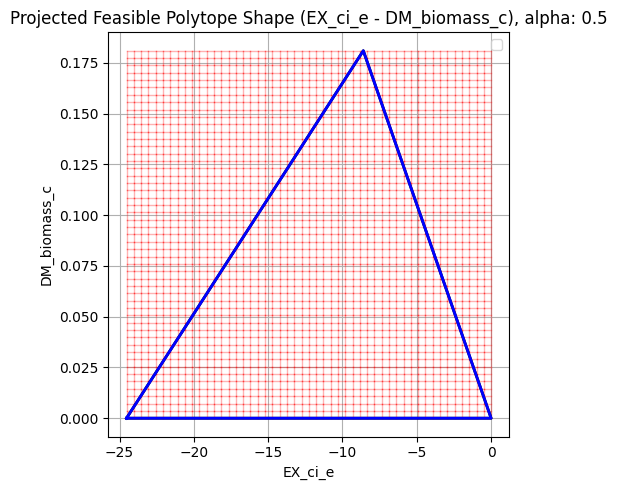

Running qualitative fva over grid feasible points...
No reactions previously selected for FVA and clustering!
Setting reactions for analysis...

Analyzing point feasibility....


100%|██████████| 1425/1425 [00:00<00:00, 2294.45it/s]


Done!



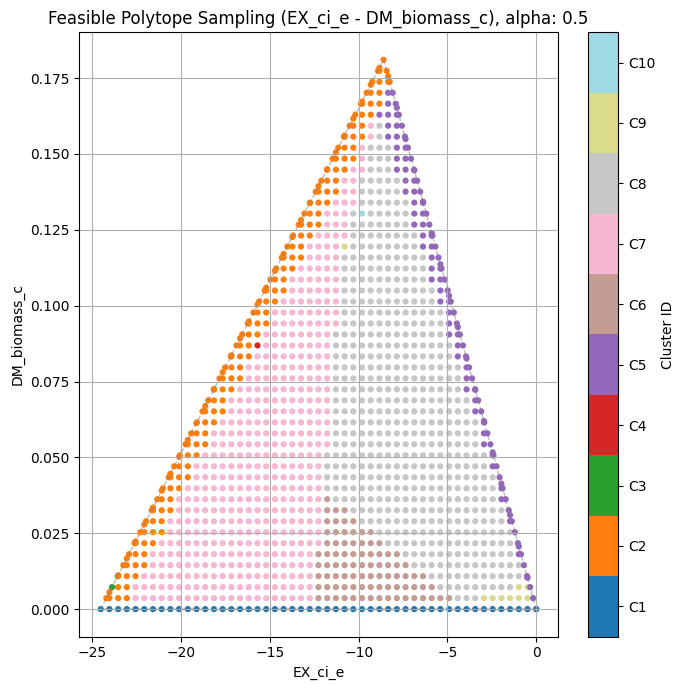

In [6]:
polytope_pipeline(n_clusters=10, alpha=alpha)


## Cluster Analysis

In [7]:
def clustering_pipeline(reaction_list, threshold=0.8, changing=False, overwrite=False):
    print("Qualitative Profiles "+"="*80+"\n")
    qualitative_profiles = diatom.clustering.get_grid_cluster_qual_profiles(threshold=threshold, changing=changing, selected_reactions=reaction_list, overwrite=overwrite)
    display(qualitative_profiles)

    print("Per Reaction Metrics "+"="*80+"\n")
    metrics_per_reaction = diatom.clustering.get_cluster_metrics_per_reaction(reaction_list, overwrite=overwrite)
    display(metrics_per_reaction)

    print("Global Metrics "+"="*80+"\n")
    global_metrics = diatom.clustering.get_cluster_global_metrics(reaction_list, overwrite=overwrite)
    display(global_metrics)

    diatom.io.merge_to_excel({"qualitative profiles": qualitative_profiles, "per reaction metrics": metrics_per_reaction, "global metrics": global_metrics})


In [8]:
df, reaction_list = diatom.clustering.reaction_scores(sort_score = True, sort_index = 5, show = True)

           votes   mean_rank
GLUDH_c        5   79.000000
LEUt_h         5  200.500000
ILEt_h         5  206.500000
BCTAI_h        5  207.000000
3MOPt_h        5  207.666667
MTHFO1_c       5  356.833333
MTHFO2_c       5  358.500000
OAAAKGt_m      4   98.833333
NAHt_h         4  126.166667
ENO_m          4  146.500000
BCTAL_h        4  202.000000
4MOPt_h        4  208.333333
IDH_m          4  366.166667
BCTAL_c        4  383.666667
DHFR1_c        4  384.500000
DHFR2_c        4  431.500000
MALOAAt_h      4  506.416667
AKGMALt_h      4  508.916667
GLUNA1t_h      4  514.833333
CA_m           3  123.833333
GLUNA1t_m      3  156.000000
GLUDH2_m       3  325.333333
ICDH_m         3  388.500000
BCTAI_c        3  390.833333
PYK_h          3  425.333333
PYC_h          3  446.666667
ASPTA_L_h      3  543.666667
XPK_c          2   65.166667
MTHFt_m        2   65.166667
ORNC_c         2   66.333333
GLYNA1t_m      2   95.166667
P5CR_c         2   97.333333
MALOAAt_m      2  155.500000
MALAKGt_m     

In [9]:
REACTIONS = [
    # BIOMASS
    "DM_biomass_c",
    
    # EXCHANGE
    "EX_co2_e",
    "EX_o2_e",
    "EX_h2o_e",
    "EX_co_e", 
    "EX_no3_e",
    "EX_photon_e",
    
    # CHLOROPLAST
    "ATPS_h",
    "ATPM_h",
    "GLNA_h",
    "GLTS_h",
    "ACCOAC_h",
    "ACOATA_h",
    "NTRIR_h",
    "PSII_u",
    "FNOR_h",
    "GDR_NADP_h",
    "RUBISO_h",
    "RUBISC_h", 
    "DXPS_h",
    "CA_h", # important for carbon fixing
    #"MEHLER_h",

    # MITOCHONDRIA
    "ATPS_m",
    "ATPM_m",
    "GLNA_m",
    "GLTS_m",
    "THD2_m",
    "GLUDH2_m",
    #"AGAS_m",

    # CYTOSOL
    "ATPS_c",
    "TAGAH_HDE_ARA_ARA_c",
    "ACOADAGAT_EPA_EPA_EPA_c",
    "ACOADAGAT_HDE_ARA_ARA_c",
    "NOR_c",
    "PAPA_EPA_EPA_c",
    "NITR_c",
    "HISD_c",
]

clustering_pipeline(reaction_list + ["ATPM_h", "PAPA_EPA_EPA_c", "CA_h"], overwrite=True)

Qualitative Profiles ================================================================================

cluster_dfs len: 10


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
GLUDH_c,0,+,++,++,+,-,+,-,NaN,--
LEUt_h,0,0+,0+,0+,++,NaN,0+,0,-0,-0
ILEt_h,0,++,++,++,++,+,++,NaN,-0,-0
BCTAI_h,0,++,++,++,++,+,++,NaN,-0,-0
3MOPt_h,0,0+,0+,0+,0+,0,0+,NaN,--,--
MTHFO1_c,0,0,NaN,0,0,0+,+,0+,NaN,+
MTHFO2_c,0,+,NaN,+,+,0+,0,0+,0+,0
OAAAKGt_m,0,-,--,--,+,+,-,+,0,0
NAHt_h,NaN,NaN,++,++,NaN,-,+,-,NaN,--
ENO_m,NaN,NaN,0,+,-,NaN,+,-,NaN,--


Per Reaction Metrics ================================================================================



,reaction_id,cluster,metric,value
0,GLUDH_c,1,minimum,0.000000e+00
1,GLUDH_c,1,maximum,2.289302e-11
2,GLUDH_c,1,mean_range,4.851278e-13
3,GLUDH_c,1,mean_midpoint,2.425639e-13
4,GLUDH_c,1,median_range,0.000000e+00
...,...,...,...,...
4395,CA_h,10,mean_abs_flux,3.721427e+00
4396,CA_h,10,std_range,0.000000e+00
4397,CA_h,10,frac_variable,1.000000e+00
4398,CA_h,10,frac_fixed,0.000000e+00


Global Metrics ================================================================================

Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value to 0.0
Reaction 'NH4t_e' not found in fva_reactions: defaulting value 

,cluster,metric,value
0,1,mean_range_all_reactions,0.097681
1,1,median_range_all_reactions,0.000000
2,1,std_range_all_reactions,3.677012
3,1,blocked_fraction_all_reactions,0.994076
4,1,rubisco_carboxylation_fraction,1.000000
...,...,...,...
155,10,nitrogen_assimilation_ratio,0.072927
156,10,carbon_assimilation_ratio,0.007802
157,10,C_to_N_uptake_ratio,15.381858
158,10,C_to_N_biomass_ratio,1.537662


In [10]:
"""
grid_x = [-50, -100, -150, -175]
grid_y = [0.3, 0.2, 0.1]

reaction_couplings = [
    ('EX_co2_e', 'RUBISC_h'),
    ('EX_o2_e', 'RUBISO_h'),
    ("RUBISC_h", "RUBISO_h"),
    ("EX_no3_e", "NTRIR_h")
]

for coupling in reaction_couplings:
    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)
    diatom.plot.plot_qFCA()
"""

'\ngrid_x = [-50, -100, -150, -175]\ngrid_y = [0.3, 0.2, 0.1]\n\nreaction_couplings = [\n    (\'EX_co2_e\', \'RUBISC_h\'),\n    (\'EX_o2_e\', \'RUBISO_h\'),\n    ("RUBISC_h", "RUBISO_h"),\n    ("EX_no3_e", "NTRIR_h")\n]\n\nfor coupling in reaction_couplings:\n    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)\n    diatom.plot.plot_qFCA()\n'